In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

from tensorflow.keras import backend as K

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

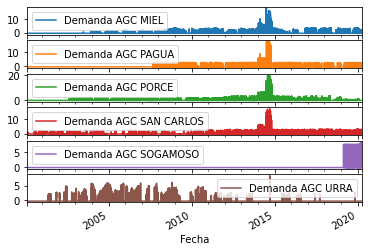

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2020-01-01']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2184, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']



window_dataset = WindowDataset.WindowGenerator(input_width=24, label_width=1, shift=1,
                              train_df=train_df, val_df=val_df, test_df=test_df,
                              inputs_columns=inputs_columns,label_columns=output_columns,batch=8)

# MODELS

## Instantiate Models

In [8]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [9]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [10]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [11]:
def generate_predictions_style_1(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 24 horas tomadas del conjunto de Test y le agrega  la
    predicción realizada para predecir la siguiente hora (hora 26) y continua  así
    hasta realizar la predicción de todas las horas del subconjunto tomado de test.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)
    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model.predict(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[0+i:24+i,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [12]:
def generate_predictions_style_2(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 23 horas tomadas del conjunto de Test y repite el úl-
    timo valor conocido (osea el valor flat_input[23,:]) para poder completar  las
    24 horas, pero esto lo hace unicamente con las series que no estan   incluidas
    en output_columns, para las series que si estan incluidas en   output_columns,
    toma el valor predicho y lo agrega como último a la serie.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            first_signals = flat_inputs[i:24,:-1]
            repeated_signals = tf.repeat(flat_inputs[23:24,:-1], i, axis=0)
            first_signals = tf.concat([first_signals,repeated_signals],axis=0)

        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [13]:
def generate_predictions_style_3(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las mismas 24 de las series que no estan incluidas en output_columns 
    y para las series que si estan incluidas allí toma los 23 valores siguiente  y
    agrega la predicción realizada, así suscesivamente hasta acabar las    predic-
    ciones.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[:24,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [14]:
def plot_comparison(signal_true,signal_pred):
    """
    Este método permite gráficar un par de señales en una sola gráfica. Para realizar esto toma
    la primer señal que contiene todos los valores del conjunto de Test y extrae unicamente  la
    ultima serie que corresponde al precio en bolsa, la segunda señal es la correspondiente   a
    las predicciones la cual inicialmente se le darán las mismas dimensiones que la señal  ori-
    ginal.
    Input:
        - signal_true: Conjunto de datos con todas las series (Incluida la serie a predecir).
        - signal_pred: Conjunto de datos con la señal predicha.
    """
    y_true = signal_true[24:,-1]
    y_pred = tf.reshape(tf.convert_to_tensor(signal_pred),[-1,1])
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

## Execute experiments

### Recurrent Neuronal Network

In [15]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 1)                 84        
Total params: 8,384
Trainable params: 8,384
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = compile_and_fit(model=custom_rnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
  1/150 [..............................] - ETA: 0s - loss: 0.8493 - mean_absolute_error: 0.7505 - mean_absolute_percentage_error: 148.5727 - symmetric_mean_absolute_percentage_error: 158.1750WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 5s 31ms/step - loss: 0.2289 - mean_absolute_error: 0.3005 - mean_absolute_percentage_error: 214.5972 - symmetric_mean_absolute_percentage_error: 77.5980 - val_loss: 0.1154 - val_mean_absolute_error: 0.2593 - val_mean_absolute_percentage_error: 271.9021 - val_symmetric_mean_absolute_percentage_error: 64.7798
Epoch 2/100
150/150 [==============================] - 4s 24ms/step - loss: 0.1222 - mean_absolute_error: 0.1941 - mean_absolute_percentag

Epoch 20/100
150/150 [==============================] - 3s 23ms/step - loss: 0.0403 - mean_absolute_error: 0.1007 - mean_absolute_percentage_error: 95.3059 - symmetric_mean_absolute_percentage_error: 33.2110 - val_loss: 0.0677 - val_mean_absolute_error: 0.1803 - val_mean_absolute_percentage_error: 175.1568 - val_symmetric_mean_absolute_percentage_error: 47.8337
Epoch 21/100
150/150 [==============================] - 4s 23ms/step - loss: 0.0296 - mean_absolute_error: 0.0968 - mean_absolute_percentage_error: 122.3773 - symmetric_mean_absolute_percentage_error: 35.1100 - val_loss: 0.0685 - val_mean_absolute_error: 0.1850 - val_mean_absolute_percentage_error: 118.5579 - val_symmetric_mean_absolute_percentage_error: 48.4495


In [17]:
val_performance['DNN'] = custom_rnn.evaluate(window_dataset.val)
performance['DNN'] = custom_rnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 4s 4ms/step - loss: 0.0738 - mean_absolute_error: 0.1882 - mean_absolute_percentage_error: 217.5742 - symmetric_mean_absolute_percentage_error: 47.5334


In [18]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

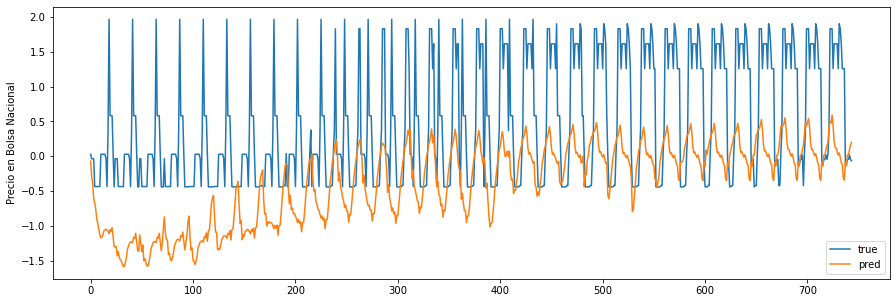

In [19]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

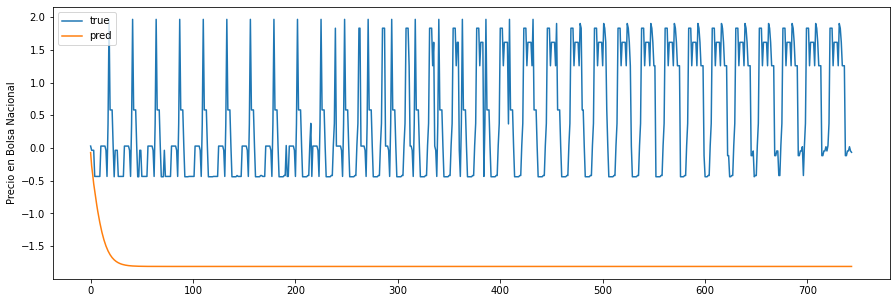

In [20]:
predicted_signal = generate_predictions_style_2(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

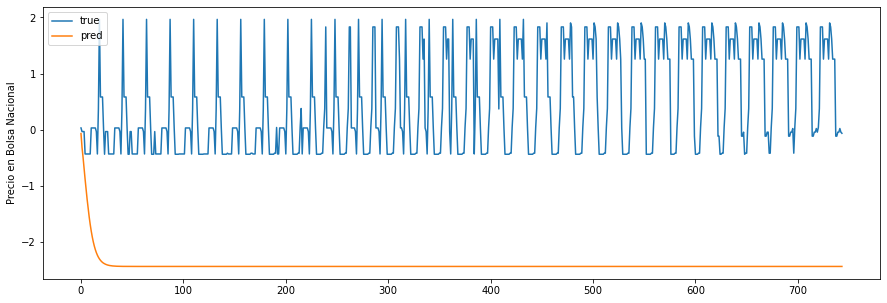

In [21]:
predicted_signal = generate_predictions_style_3(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

### Long Short Term Memory

In [22]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                56108     
_________________________________________________________________
dense_1 (Dense)              (None, 85)                7140      
Total params: 63,248
Trainable params: 63,248
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = compile_and_fit(model=custom_lstm, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 22ms/step - loss: 0.2313 - mean_absolute_error: 0.2263 - mean_absolute_percentage_error: 390.6915 - symmetric_mean_absolute_percentage_error: 64.2001 - val_loss: 0.1666 - val_mean_absolute_error: 0.3144 - val_mean_absolute_percentage_error: 128.7071 - val_symmetric_mean_absolute_percentage_error: 72.8847
Epoch 2/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0531 - mean_absolute_error: 0.1469 - mean_absolute_percentage_error: 104.3107 - symmetric_mean_absolute_percentage_error: 47.7478 - val_loss: 0.1267 - val_mean_absolute_error: 0.2711 - val_mean_absolute_percentage_error: 415.9791 - val_symmetric_mean_absolute_percentage_error: 64.6035
Epoch 3/100
150/150 [==============================] - 1s 8ms/step - loss: 0.1354 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 100.4310 - symmetric_mean_absolute_percentage_error: 44.1663 - val_loss: 0.0791 - val_mean_absolute_error: 0.2006 - val_mean_ab

150/150 [==============================] - 1s 8ms/step - loss: 0.0247 - mean_absolute_error: 0.0921 - mean_absolute_percentage_error: 83.7864 - symmetric_mean_absolute_percentage_error: 32.6232 - val_loss: 0.0639 - val_mean_absolute_error: 0.1754 - val_mean_absolute_percentage_error: 206.3487 - val_symmetric_mean_absolute_percentage_error: 46.6769
Epoch 22/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0403 - mean_absolute_error: 0.0894 - mean_absolute_percentage_error: 128.1507 - symmetric_mean_absolute_percentage_error: 30.1379 - val_loss: 0.0603 - val_mean_absolute_error: 0.1681 - val_mean_absolute_percentage_error: 107.7428 - val_symmetric_mean_absolute_percentage_error: 45.6294
Epoch 23/100
150/150 [==============================] - 1s 9ms/step - loss: 0.0231 - mean_absolute_error: 0.0819 - mean_absolute_percentage_error: 66.8116 - symmetric_mean_absolute_percentage_error: 29.3398 - val_loss: 0.0605 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percen

In [24]:
val_performance['LSTM'] = custom_lstm.evaluate(window_dataset.val)
performance['LSTM'] = custom_lstm.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 3s 3ms/step - loss: 0.0613 - mean_absolute_error: 0.1668 - mean_absolute_percentage_error: 298.6618 - symmetric_mean_absolute_percentage_error: 45.4667


In [25]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

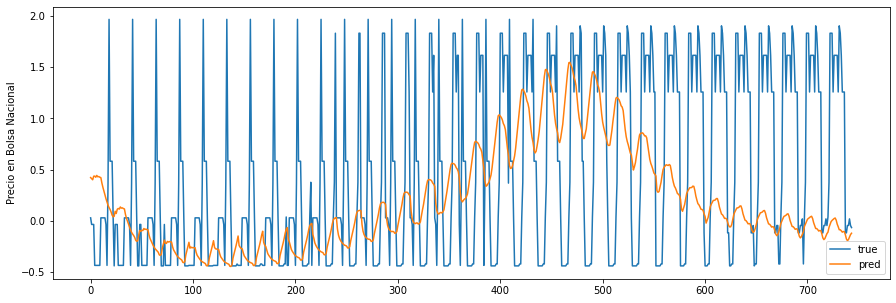

In [26]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

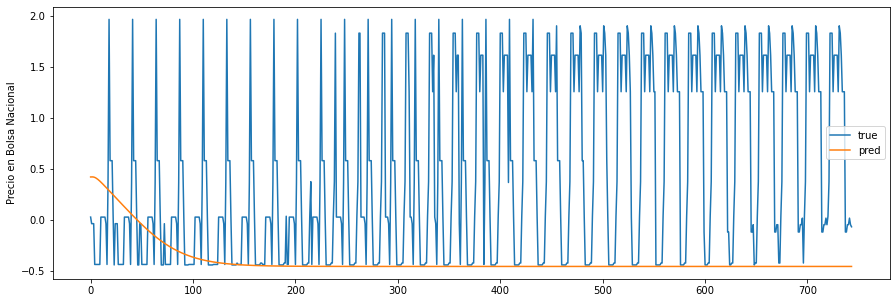

In [27]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

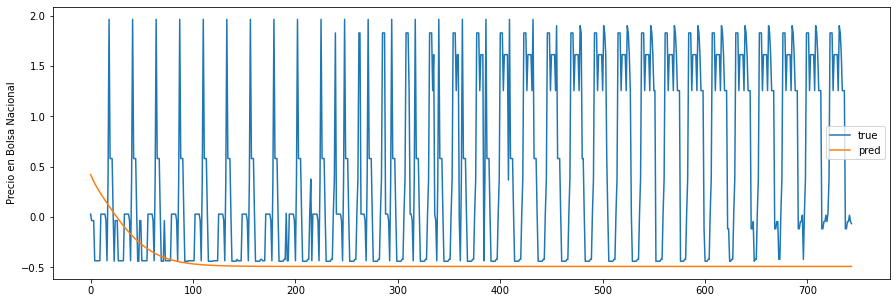

In [28]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [29]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                42330     
_________________________________________________________________
dense_2 (Dense)              (None, 85)                7140      
Total params: 49,470
Trainable params: 49,470
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = compile_and_fit(model=custom_gru, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 12s 82ms/step - loss: 0.1845 - mean_absolute_error: 0.2080 - mean_absolute_percentage_error: 125.3040 - symmetric_mean_absolute_percentage_error: 59.6625 - val_loss: 0.0683 - val_mean_absolute_error: 0.1703 - val_mean_absolute_percentage_error: 209.6005 - val_symmetric_mean_absolute_percentage_error: 43.7319
Epoch 2/100
150/150 [==============================] - 10s 65ms/step - loss: 0.0480 - mean_absolute_error: 0.1151 - mean_absolute_percentage_error: 73.3117 - symmetric_mean_absolute_percentage_error: 39.2137 - val_loss: 0.0630 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 628.8671 - val_symmetric_mean_absolute_percentage_error: 42.4977ol
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0476 - mean_absolute_error: 0.1184 - mean_absolute_percentage_error: 170.2699 - symmetric_mean_absolute_percentage_error: 40.7736
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001000

In [31]:
val_performance['GRU'] = custom_gru.evaluate(window_dataset.val)
performance['GRU'] = custom_gru.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 6s 6ms/step - loss: 0.0536 - mean_absolute_error: 0.1443 - mean_absolute_percentage_error: 208.9914 - symmetric_mean_absolute_percentage_error: 39.4071


In [32]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

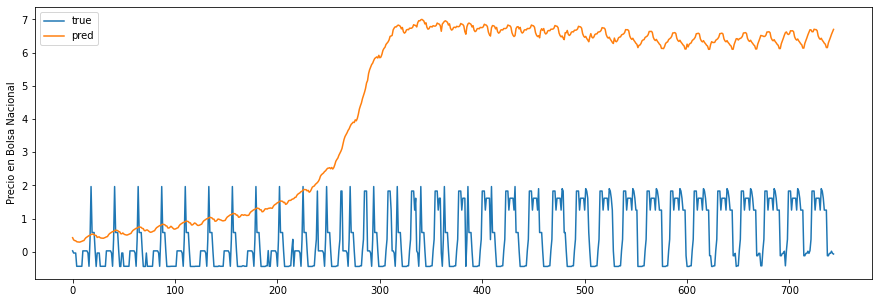

In [33]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

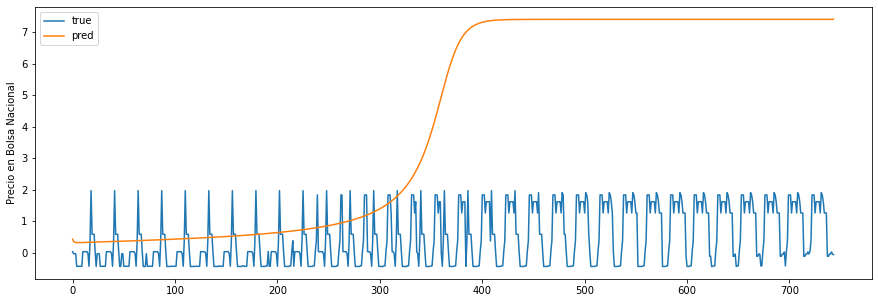

In [34]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

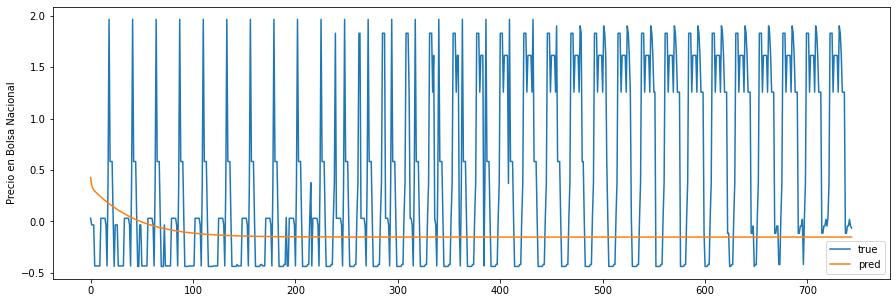

In [35]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [36]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            10944     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)               

In [37]:
history = compile_and_fit(model=custom_cnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 20ms/step - loss: 1.1040 - mean_absolute_error: 0.7262 - mean_absolute_percentage_error: 759.9556 - symmetric_mean_absolute_percentage_error: 129.6411 - val_loss: 0.2549 - val_mean_absolute_error: 0.3951 - val_mean_absolute_percentage_error: 365.6272 - val_symmetric_mean_absolute_percentage_error: 77.4303
Epoch 2/100
150/150 [==============================] - 1s 7ms/step - loss: 0.7218 - mean_absolute_error: 0.5849 - mean_absolute_percentage_error: 611.6853 - symmetric_mean_absolute_percentage_error: 113.4125 - val_loss: 0.1757 - val_mean_absolute_error: 0.3259 - val_mean_absolute_percentage_error: 216.2899 - val_symmetric_mean_absolute_percentage_error: 70.6509
Epoch 3/100
150/150 [==============================] - 1s 7ms/step - loss: 0.5328 - mean_absolute_error: 0.5058 - mean_absolute_percentage_error: 426.8109 - symmetric_mean_absolute_percentage_error: 107.2008 - val_loss: 0.1727 - val_mean_absolute_error: 0.3181 - val_mean

150/150 [==============================] - 1s 8ms/step - loss: 0.3939 - mean_absolute_error: 0.4147 - mean_absolute_percentage_error: 307.9427 - symmetric_mean_absolute_percentage_error: 94.8675 - val_loss: 0.1333 - val_mean_absolute_error: 0.2803 - val_mean_absolute_percentage_error: 151.7900 - val_symmetric_mean_absolute_percentage_error: 70.1565
Epoch 22/100
150/150 [==============================] - 1s 7ms/step - loss: 0.2801 - mean_absolute_error: 0.4018 - mean_absolute_percentage_error: 482.0194 - symmetric_mean_absolute_percentage_error: 99.3777 - val_loss: 0.1328 - val_mean_absolute_error: 0.2790 - val_mean_absolute_percentage_error: 177.6814 - val_symmetric_mean_absolute_percentage_error: 69.5610
Epoch 23/100
150/150 [==============================] - 1s 7ms/step - loss: 0.3381 - mean_absolute_error: 0.4100 - mean_absolute_percentage_error: 372.3143 - symmetric_mean_absolute_percentage_error: 97.6448 - val_loss: 0.1363 - val_mean_absolute_error: 0.2817 - val_mean_absolute_perc

In [38]:
val_performance['CNN'] = custom_cnn.evaluate(window_dataset.val)
performance['CNN'] = custom_cnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 3s 2ms/step - loss: 0.1397 - mean_absolute_error: 0.2811 - mean_absolute_percentage_error: 314.2799 - symmetric_mean_absolute_percentage_error: 68.2629


In [39]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

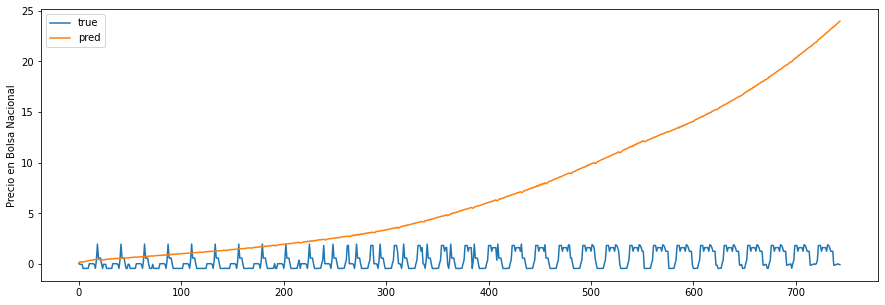

In [40]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

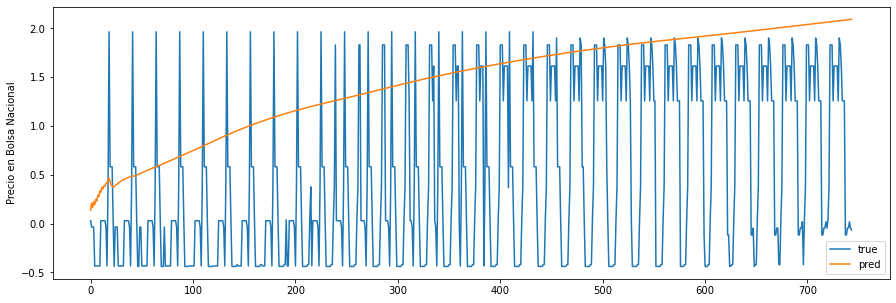

In [41]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

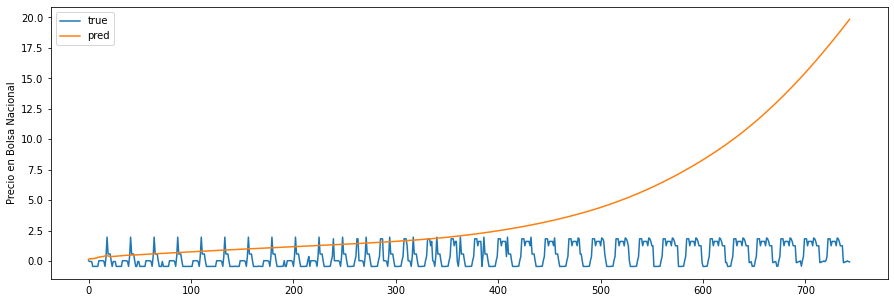

In [42]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [43]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.073753,0.188223,217.574249,47.533379
LSTM,0.061294,0.166839,298.661804,45.466736
GRU,0.053641,0.144315,208.991379,39.407082
CNN,0.139688,0.281055,314.279907,68.262894


In [44]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.074158,0.197393,18.337860,16.317362
LSTM,0.063989,0.178666,23.035378,14.615509
GRU,0.060435,0.155821,18.250200,12.760076
CNN,0.166141,0.294794,47.017712,22.779432


# MODELO DE DATOS PROPIO

In [45]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA',      'Generacion CHIVOR',
                  'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
                  'Generacion GUAVIO', 'Generacion LA TASAJERA',   'Generacion MIEL',
                  'Generacion PAGUA', 'Generacion PLAYAS',        'Generacion PORCE',
                  'Generacion SAN CARLOS', 'Generacion SOGAMOSO',  'Generacion URRA',
                  '$kWh']

output_columns = ['$kWh']

column_indices = {name: i for i, name in enumerate(full_df)}
times = 24
shift = 1

In [46]:
samples = train_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_train, y_train = custom_window_generator.data_build(train_df)
train_generator = custom_window_generator.batch_generator(x=x_train,y=y_train,batches=8)

x_batch, y_batch = next(train_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [47]:
samples = val_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_val, y_val = custom_window_generator.data_build(val_df)
val_generator = custom_window_generator.batch_generator(x_val, y_val,batches=8)

x_batch, y_batch = next(val_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [48]:
samples = test_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_test, y_test = custom_window_generator.data_build(test_df)
test_generator = custom_window_generator.batch_generator(x_test, y_test,batches=8,shuffle=False)

x_batch, y_batch = next(test_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

## Instantiate Models

In [49]:
custom_rnn_2  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm_2 = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru_2  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn_2  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Execute Experiments

### Recurrent Neuronal Network

In [50]:
history = compile_and_fit(model=custom_rnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 5s 33ms/step - loss: 0.3492 - mean_absolute_error: 0.2741 - mean_absolute_percentage_error: 303.9096 - symmetric_mean_absolute_percentage_error: 1772.0254 - val_loss: 0.1027 - val_mean_absolute_error: 0.2492 - val_mean_absolute_percentage_error: 294.9077 - val_symmetric_mean_absolute_percentage_error: 1441.1289
Epoch 2/100
150/150 [==============================] - 3s 23ms/step - loss: 0.1124 - mean_absolute_error: 0.1791 - mean_absolute_percentage_error: 161.4702 - symmetric_mean_absolute_percentage_error: 1292.5955 - val_loss: 0.0930 - val_mean_absolute_error: 0.2219 - val_mean_absolute_percentage_error: 429.3348 - val_symmetric_mean_absolute_percentage_error: 1349.3403
Epoch 3/100
148/150 [============================>.] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 104.0950 - symmetric_mean_absolute_percentage_error: 1264.7809
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

In [51]:
val_performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(val_generator,steps=100)
performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 4ms/step - loss: 0.0493 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 71.3484 - symmetric_mean_absolute_percentage_error: 981.8851


In [52]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

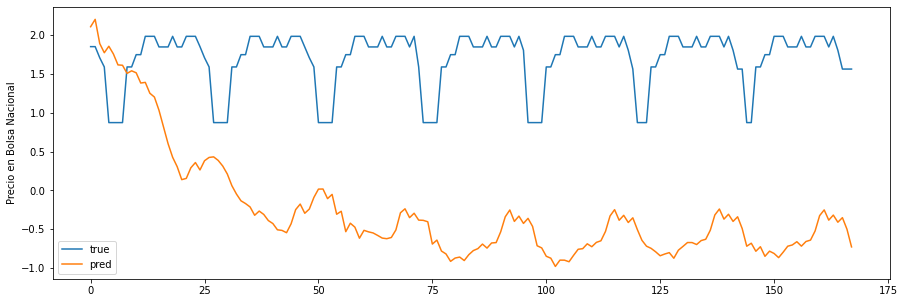

In [53]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

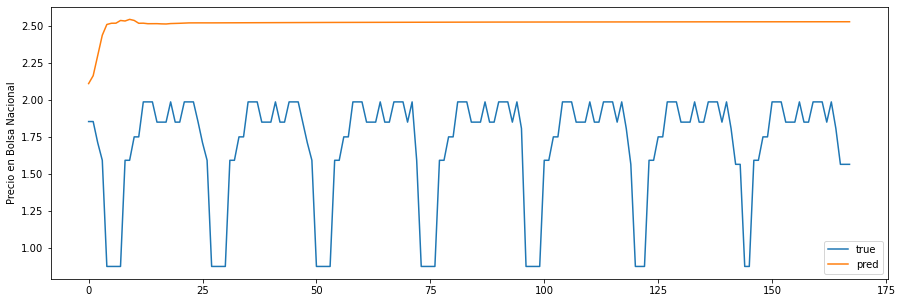

In [54]:
predictions = generate_predictions_style_2(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

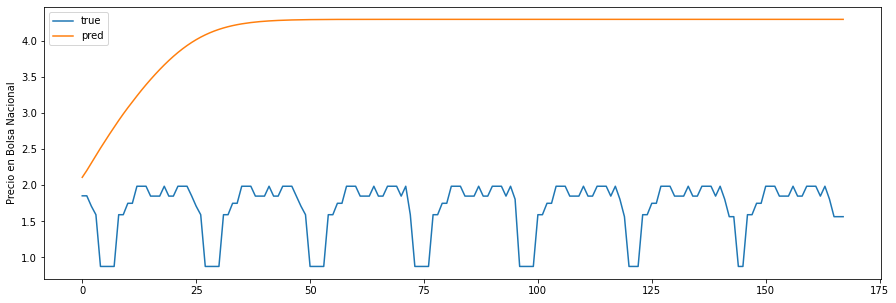

In [55]:
predictions = generate_predictions_style_3(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

### Long Short Term Memory

In [56]:
history = compile_and_fit(model=custom_lstm_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 20ms/step - loss: 0.2611 - mean_absolute_error: 0.2338 - mean_absolute_percentage_error: 199.7346 - symmetric_mean_absolute_percentage_error: 1537.3612 - val_loss: 0.1316 - val_mean_absolute_error: 0.2784 - val_mean_absolute_percentage_error: 627.4554 - val_symmetric_mean_absolute_percentage_error: 1675.5513
Epoch 2/100
150/150 [==============================] - 1s 8ms/step - loss: 0.1232 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 123.6173 - symmetric_mean_absolute_percentage_error: 1197.3583 - val_loss: 0.0999 - val_mean_absolute_error: 0.2332 - val_mean_absolute_percentage_error: 767.1448 - val_symmetric_mean_absolute_percentage_error: 1444.9481
Epoch 3/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0418 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 95.3250 - symmetric_mean_absolute_percentage_error: 957.4077 - val_loss: 0.0898 - val_mean_absolute_error: 0.2143 - val

In [57]:
val_performance['LSTM-CustomDataset'] = custom_cnn.evaluate(val_generator,steps=100)
performance['LSTM-CustomDataset'] = custom_cnn.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 3ms/step - loss: 0.1519 - mean_absolute_error: 0.2712 - mean_absolute_percentage_error: 293.7018 - symmetric_mean_absolute_percentage_error: 1602.8306


In [58]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

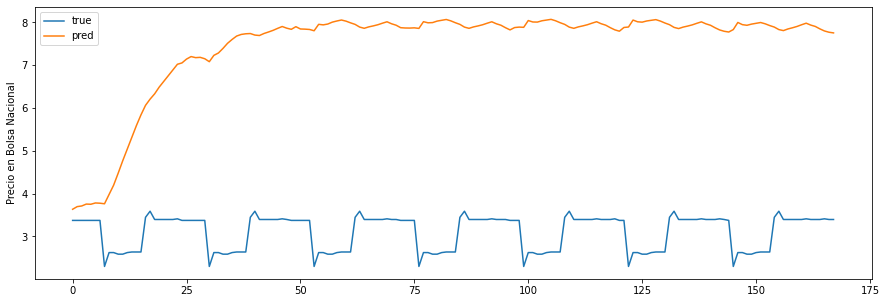

In [59]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

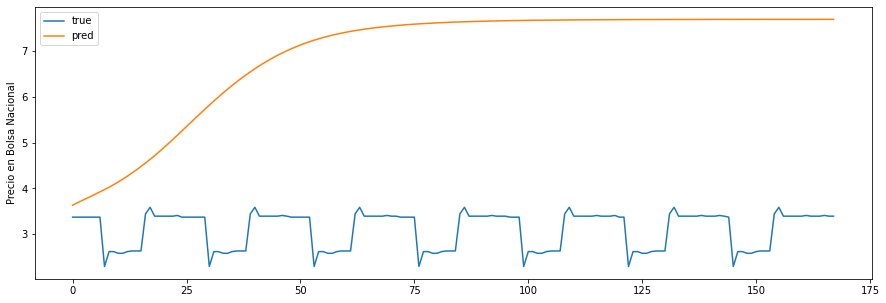

In [60]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

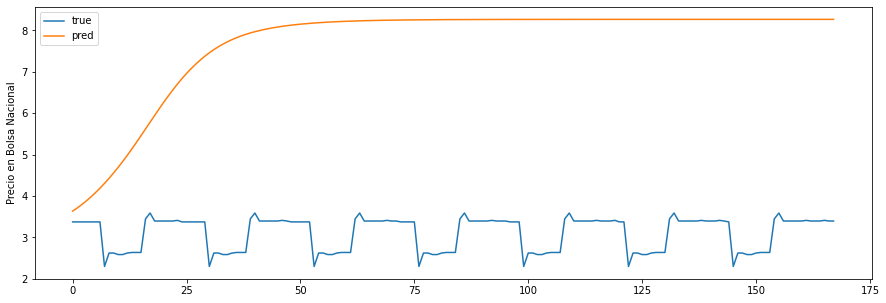

In [61]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [62]:
history = compile_and_fit(model=custom_gru_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 23ms/step - loss: 0.3310 - mean_absolute_error: 0.2432 - mean_absolute_percentage_error: 159.8507 - symmetric_mean_absolute_percentage_error: 1479.0820 - val_loss: 0.0787 - val_mean_absolute_error: 0.1967 - val_mean_absolute_percentage_error: 174.0491 - val_symmetric_mean_absolute_percentage_error: 1152.5183
Epoch 2/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0709 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 125.1110 - symmetric_mean_absolute_percentage_error: 916.5296 - val_loss: 0.0640 - val_mean_absolute_error: 0.1856 - val_mean_absolute_percentage_error: 732.2585 - val_symmetric_mean_absolute_percentage_error: 1145.0392
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.1002 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 158.2247 - symmetric_mean_absolute_percentage_error: 1056.9943
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00

In [63]:
val_performance['GRU-CustomDataset'] = custom_gru_2.evaluate(val_generator,steps=100)
performance['GRU-CustomDataset'] = custom_gru_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 3ms/step - loss: 0.0580 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 102.6179 - symmetric_mean_absolute_percentage_error: 991.7615


In [64]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

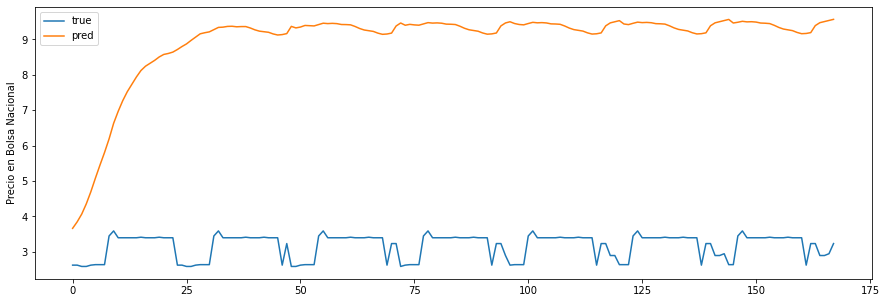

In [65]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

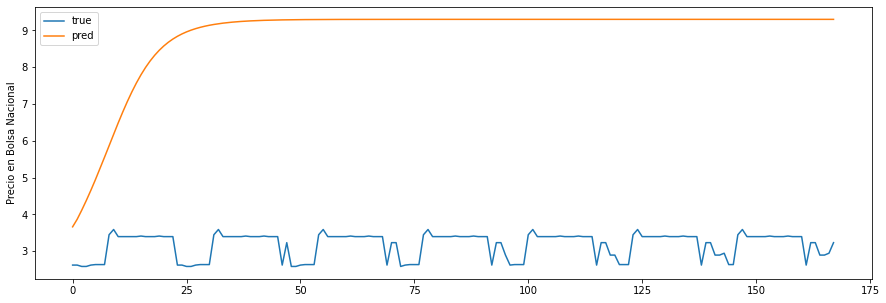

In [66]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

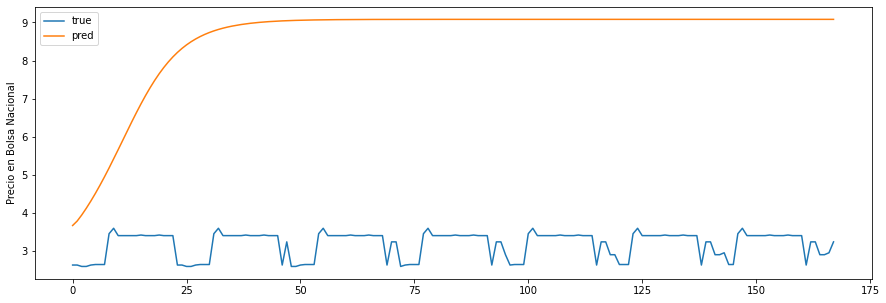

In [67]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [68]:
history = compile_and_fit(model=custom_cnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 18ms/step - loss: 0.9893 - mean_absolute_error: 0.7035 - mean_absolute_percentage_error: 1502.8527 - symmetric_mean_absolute_percentage_error: 3069.5049 - val_loss: 0.2428 - val_mean_absolute_error: 0.3846 - val_mean_absolute_percentage_error: 923.5875 - val_symmetric_mean_absolute_percentage_error: 1932.0046
Epoch 2/100
144/150 [===========================>..] - ETA: 0s - loss: 0.5238 - mean_absolute_error: 0.5193 - mean_absolute_percentage_error: 704.0925 - symmetric_mean_absolute_percentage_error: 2593.8115
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 [==============================] - 1s 6ms/step - loss: 0.5310 - mean_absolute_error: 0.5244 - mean_absolute_percentage_error: 694.3450 - symmetric_mean_absolute_percentage_error: 2625.6218 - val_loss: 0.2750 - val_mean_absolute_error: 0.4365 - val_mean_absolute_percentage_error: 1381.3680 - val_symmetric_mean_absolute_percentage_error:

Epoch 21/100
150/150 [==============================] - 1s 7ms/step - loss: 0.3872 - mean_absolute_error: 0.4605 - mean_absolute_percentage_error: 524.0903 - symmetric_mean_absolute_percentage_error: 2486.2437 - val_loss: 0.1365 - val_mean_absolute_error: 0.2846 - val_mean_absolute_percentage_error: 309.1885 - val_symmetric_mean_absolute_percentage_error: 1610.1886
Epoch 22/100
150/150 [==============================] - 1s 6ms/step - loss: 0.2826 - mean_absolute_error: 0.4154 - mean_absolute_percentage_error: 506.5589 - symmetric_mean_absolute_percentage_error: 2430.2698 - val_loss: 0.1433 - val_mean_absolute_error: 0.2818 - val_mean_absolute_percentage_error: 303.4615 - val_symmetric_mean_absolute_percentage_error: 1596.2930


In [69]:
val_performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(val_generator,steps=100)
performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 3ms/step - loss: 0.1484 - mean_absolute_error: 0.2868 - mean_absolute_percentage_error: 426.4234 - symmetric_mean_absolute_percentage_error: 1687.3063


In [70]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

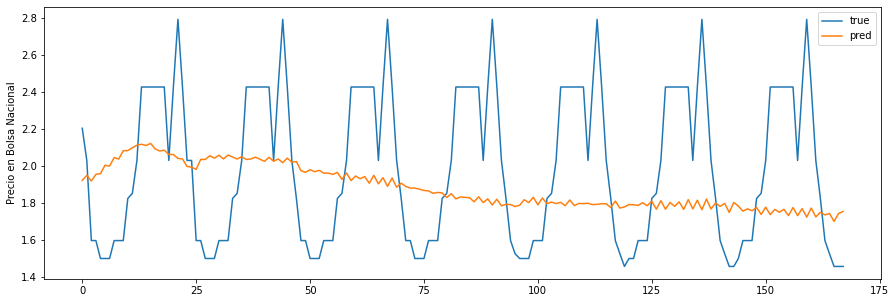

In [71]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

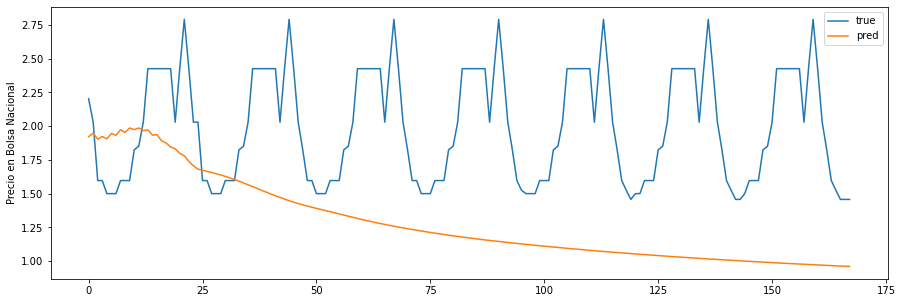

In [72]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

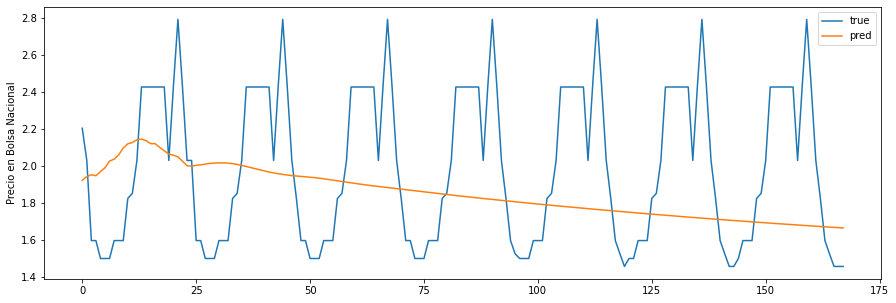

In [73]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [74]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.073753,0.188223,217.574249,47.533379
LSTM,0.061294,0.166839,298.661804,45.466736
GRU,0.053641,0.144315,208.991379,39.407082
CNN,0.139688,0.281055,314.279907,68.262894
RNN-CustomDataset,0.049304,0.154088,71.348419,981.885071
LSTM-CustomDataset,0.151941,0.271197,293.701782,1602.830566
GRU-CustomDataset,0.057954,0.154239,102.617897,991.761536
CNN-CustomDataset,0.148384,0.286812,426.423401,1687.306274


In [75]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.074158,0.197393,18.337860,16.317362
LSTM,0.063989,0.178666,23.035378,14.615509
GRU,0.060435,0.155821,18.250200,12.760076
CNN,0.166141,0.294794,47.017712,22.779432
RNN-CustomDataset,0.066805,0.191940,15.180783,379.508423
LSTM-CustomDataset,0.187187,0.323357,43.897526,600.600037
GRU-CustomDataset,0.077880,0.179672,16.599693,351.100555
CNN-CustomDataset,0.140670,0.283225,37.169987,517.277100
